# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
target = 'EPA'
folder = 'MP-EPA'

r_folder = f'models/{folder}'
t_folder = f'targets/{folder}'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std_name':      f'{r_folder}/train_dataset_std.pt',
    'r_std_parameters_name':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data_name': f'{r_folder}/uncertainty_data.json',
    'model_name':              f'{r_folder}/model.pt',
    'dt_param_name':           f'{r_folder}/dataset_parameters.json',
    't_dataset_name':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
r_dataset_std = torch.load(files_names['r_dataset_std_name'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data_name'])

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters_name'], to='torch')

# Load dataset parameters data
r_dataset_parameters = cld.load_json(files_names['dt_param_name'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Prediciton dataset

In [18]:
# Load the standardized dataset, with corresponding labels and parameters
t_dataset = torch.load(files_names['t_dataset_name'])

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(r_dataset_parameters['target']) if t == target][0]

# Select the target we want
for data in t_dataset:
    data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

# Select the target we want
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

/tmp/ipykernel_567059/400360720.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_dataset = torch.load(files_names['t_dataset_name'])


# Load model and make predictions

In [ ]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model_name'], purpose='eval')
model

In [ ]:
# Compute predictions
predictions, uncertainties, are_interpolated = clm.make_predictions(r_dataset_std,
                                                                    t_dataset_std, model,
                                                                    r_std_parameters, r_uncertainty_data)

# Plot predictions

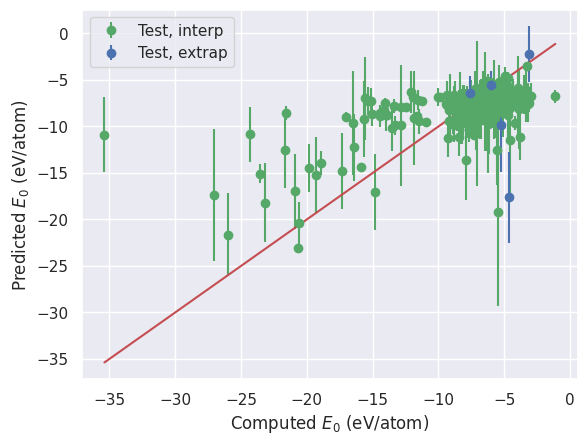

In [24]:
xpred = ground_truths[are_interpolated]
ypred = predictions[are_interpolated]
yerr  = uncertainties[are_interpolated]
plt.errorbar(xpred, ypred, yerr=np.abs(yerr),
             fmt='og', label='Interpolation')

xpred = ground_truths[~are_interpolated]
ypred = predictions[~are_interpolated]
yerr  = uncertainties[~are_interpolated]
plt.errorbar(xpred, ypred, yerr=np.abs(yerr),
             fmt='ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([ground_truths, predictions])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-prediction-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

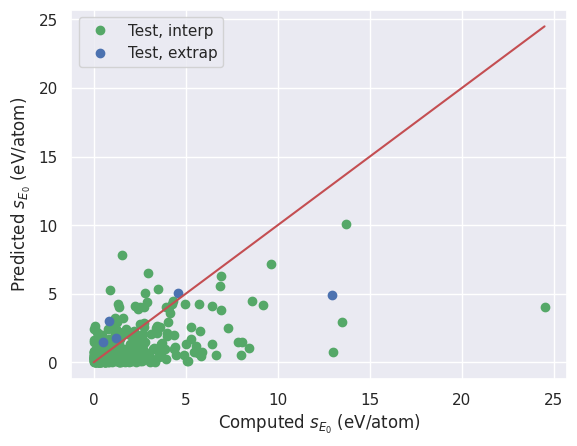

In [25]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()